# MMP Policy Evaluation: Descriptive Analysis

### 

<i> Maggie Hilderbran, Ryan Treves

**TO DO:**

-

##### 0. Set-up.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import yaml
from pathlib import Path
from IPython.display import clear_output
import sys

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# turn off warning messages
warnings.filterwarnings('ignore')

In [2]:
# import & use utility functions sitting in 'main.py'
sys.path.append('../../../ca_mmp')
import main
import scrape_facility_reports as sr

##### 1. Reading in and preprocessing data.

In [3]:
print('Reading in configuration and data files.')
clear_output(wait=True)

# read in configuration file
print('Reading in configuration file.')
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
data_path = Path(configs['CIWQS_data_path'])
clear_output(wait=True)

# read in data
# print('Reading violations file.')
# violations = pd.read_excel(data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str})
# clear_output(wait=True)
print('Reading enforcements file.')
enforcements = pd.read_csv(data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID', 'NPDES # CA#': 'NPDES# CA#'}, inplace=True)
clear_output(wait=True)
# print('Reading enforcements-violations crosswalk file.')
# enf_viol_links = pd.read_excel(data_path / 'Copy-of-RegMeasViolations.xlsx', dtype={'Violation ID': object})
# clear_output(wait=True)
# print('Reading DMR values file.')
# dmr_values = pd.read_csv(data_path / 'CA_dmrs_20221123.csv',
#                          parse_dates=['monitoring_period_end_date'],
#                          date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
# clear_output(wait=True)

Reading enforcements file.


In [4]:
enforcements['effective_year'] = [i.year for i in enforcements['EFFECTIVE DATE.1']]

print('Cleaning enforcements data.')
enforcements_npdes = main.clean_enforcements(enforcements, mmp_only=False)
enforcements_mmp = main.clean_enforcements(enforcements, mmp_only=True)
clear_output(wait=True)

Cleaning enforcements data.


In [5]:
# print('Cleaning violations data.')
# # filter violations table to MMP non-exempt violations
# violations_mmp = main.clean_violations(violations, mmp_only=True, effluent_only=False)
# clear_output(wait=True)

In [6]:
# subset to only EPLs and estimate EPL issuance dates (NB: 'valid' = status is not 'Withdrawn' or 'Draft')
print('Identifying EPLs and estimating issuance dates.\n')
enforcements_mmp_epl = main.get_epls(enforcements_mmp, issuance_dates_only=False, valid_only=False)  # estimating using 'EFFECTIVE DATE.1' as a backup
clear_output(wait=True)

Identifying EPLs and estimating issuance dates.



In [7]:
# link enforcements and violations data (result: table of all violations that are linked to an MMP enforcement action)
# print('Linking EPLs to MMP-eligible violations.')
# violations_mmp_enforced = enf_viol_links.merge(enforcements_mmp, how='right', left_on='Reg Measure ID',
#                                           right_on='ENFORCEMENT ID (EID)')
# violations_mmp_enforced.drop('Reg Measure ID', axis=1, inplace=True)
# violations_mmp_enforced.rename(columns={'Violation ID': 'VIOLATION ID (VID)'}, inplace=True)
# violations_mmp_enforced_merged = violations_mmp_enforced.merge(violations_mmp, on=['VIOLATION ID (VID)'], how='inner')
#
# violations_mmp_epl = enf_viol_links.merge(enforcements_mmp_epl, how='right', left_on='Reg Measure ID',
#                                           right_on='ENFORCEMENT ID (EID)')
# violations_mmp_epl.drop('Reg Measure ID', axis=1, inplace=True)
# violations_mmp_epl.rename(columns={'Violation ID': 'VIOLATION ID (VID)'}, inplace=True)
#
# violations_mmp_epl_merged = violations_mmp_epl.merge(violations_mmp, on=['VIOLATION ID (VID)'], how='inner')
# clear_output(wait=True)

##### 2. _____

In [8]:
treated_regions = ['2', '3', '4', '5S', '5R', '5F']

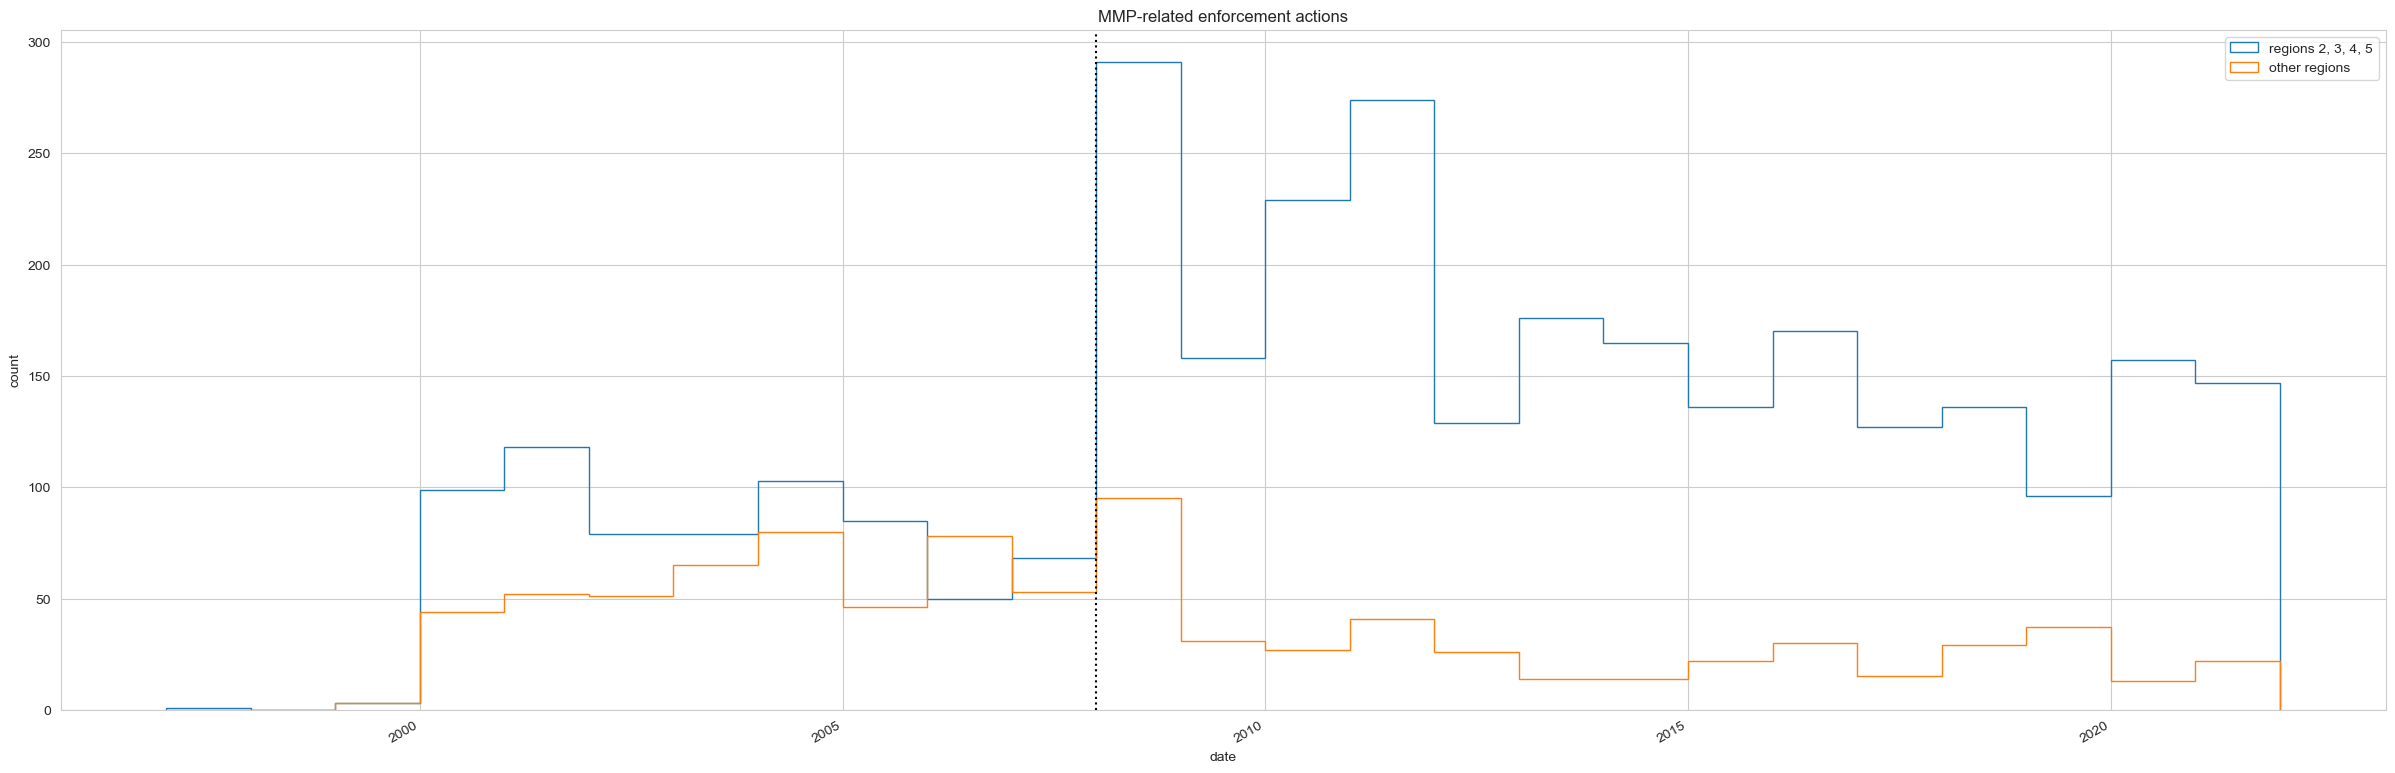

In [9]:
a = enforcements_mmp[enforcements_mmp['REGION'].isin(treated_regions)]['effective_year']
b = enforcements_mmp[~enforcements_mmp['REGION'].isin(treated_regions)]['effective_year']
bins = np.arange(np.min(enforcements_mmp['effective_year']), np.max(enforcements_mmp['effective_year'])+1)

fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(a, bins=bins, histtype='step')
ax.hist(b, bins=bins, histtype='step')
ax.axvline(x=2008, linestyle=':', color='k')
ax.legend(['regions 2, 3, 4, 5', 'other regions'])
fig.autofmt_xdate()
ax.set_title('MMP-related enforcement actions')
ax.set_xlabel('date')
ax.set_ylabel('count');

In [38]:
a = enforcements_mmp[enforcements_mmp['REGION'].isin(treated_regions)].groupby('effective_year', as_index=False).agg(n_actions=pd.NamedAgg(column='ENFORCEMENT ID (EID)', aggfunc=lambda x: x.nunique()))
b = enforcements_mmp[~enforcements_mmp['REGION'].isin(treated_regions)].groupby('effective_year', as_index=False).agg(n_actions=pd.NamedAgg(column='ENFORCEMENT ID (EID)', aggfunc=lambda x: x.nunique()))

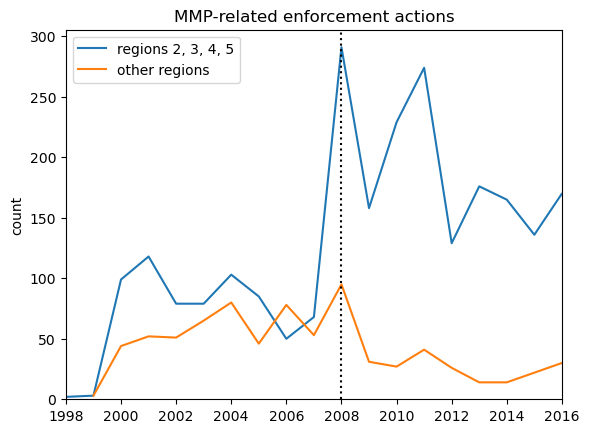

In [40]:
plt.style.use('default')
plt.plot(a['effective_year'], a['n_actions'], label='test2')
plt.plot(b['effective_year'], b['n_actions'], label='test2')
plt.axvline(x=2008, linestyle=':', color='k')
plt.legend(['regions 2, 3, 4, 5', 'other regions'])
fig.autofmt_xdate()
plt.title('MMP-related enforcement actions')
plt.xlim(1998, 2016)
plt.ylim(0,None)
plt.xlabel('')
plt.ylabel('count');
plt.savefig('enforcement_fig.png', dpi=200)

In [11]:
# a = violations_mmp_enforced_merged[violations_mmp_enforced_merged['REGION'].isin(treated_regions)]['effective_year']
# b = violations_mmp_enforced_merged[~violations_mmp_enforced_merged['REGION'].isin(treated_regions)]['effective_year']
# bins = np.arange(np.min(violations_mmp_enforced_merged['effective_year']), np.max(violations_mmp_enforced_merged['effective_year'])+1)
#
# fig, ax = plt.subplots(1, 1, figsize=(30,10))
# ax.hist(a, bins=bins, histtype='step')
# ax.hist(b, bins=bins, histtype='step')
# ax.axvline(x=2008, linestyle=':', color='k')
# ax.legend(['regions 2, 3, 4, 5', 'other regions'])
# fig.autofmt_xdate()
# ax.set_title('MMP-related enforcement actions, counted by # of violations enforced')
# ax.set_xlabel('date')
# ax.set_ylabel('count');